## Imports:

In [ ]:
import cv2
import matplotlib.pyplot as plt
import dlib
from google.colab.patches import cv2_imshow
from imutils import face_utils , paths
import imutils
import numpy as np
import pandas as pd
import os 

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D , Dropout , Flatten , Dense , Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical ,plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Downloading Data:

In [ ]:
!rm -vr ~/.kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 777 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
api_token = {"username":"yoyaadel","key":"268cb7d170de44381b8f8c02b2b74f72"}

import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# %%capture
# !kaggle datasets download -d wobotintelligence/face-mask-detection-dataset
# !unzip /content/face-mask-detection-dataset.zip
%%capture
!kaggle datasets download -d pranavsingaraju/facemask-detection-dataset-20000-images
!unzip /content/facemask-detection-dataset-20000-images.zip

## Dataset Sample:

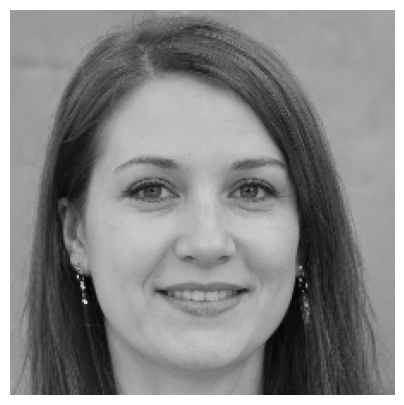

In [ ]:
file='/content/new_without_mask/seed0000.png'
without_mask_1 = cv2.imread(file)
plt.figure(figsize =(5,5))
plt.imshow(without_mask_1)
plt.axis('off')
plt.show()

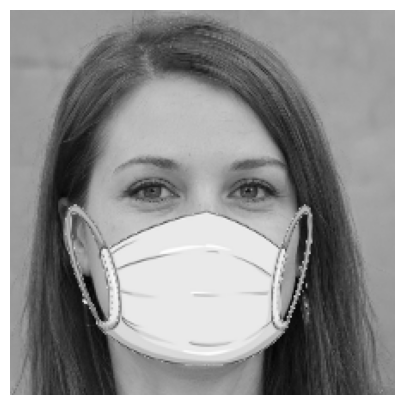

In [ ]:
file='/content/new_with_mask/with-mask-default-mask-seed0000.png'
with_mask_1 = cv2.imread(file)
plt.figure(figsize =(5,5))
plt.imshow(with_mask_1)
plt.axis('off')
plt.show()

## Preparing Dataset:

In [ ]:
dataset_with_mask= "/content/new_with_mask"
dataset_without_mask= "/content/new_without_mask"

imagePaths=list(imutils.paths.list_images(dataset_with_mask))
imagePaths2=list(imutils.paths.list_images(dataset_without_mask))
image_path=imagePaths[:5000]+ imagePaths2[:5000]

In [ ]:
def data_loader(image_path):
  images=[]
  labels=[]

  for i in image_path:
      label=i.split(os.path.sep)[-2]
      labels.append(label)
      image = load_img(i,target_size=(96,96))
      image = img_to_array(image)
      image = preprocess_input(image)
      images.append(image)
  images = np.array(images,dtype='float32')
  labels = np.array(labels)
  return images , labels

In [ ]:
images,labels= data_loader(image_path)

In [ ]:
def prepare_label(labels):
  lb=LabelBinarizer()
  labels = lb.fit_transform(labels)
  labels = to_categorical(labels)
  return labels, lb

In [ ]:
labels_final,lb= prepare_label(labels)

# Split Data:

In [ ]:
# split train and test 
train_Xx,test_X,train_Yy,test_Y = train_test_split(images,labels_final,test_size=0.20,random_state=123,stratify=labels)

In [ ]:
# split train and validation
train_X,val_X,train_Y,val_Y = train_test_split(train_Xx,train_Yy,test_size=0.20,random_state=123,stratify=train_Yy)

## Model:

In [ ]:
mobile_netModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(96, 96, 3)))
Modell = mobile_netModel.output
Modell = Flatten(name="flatten")(Modell)
Modell = Dense(128, activation="relu")(Modell)
Modell = Dropout(0.5)(Modell)
Modell = Dense(2, activation="softmax")(Modell)
model = Model(inputs=mobile_netModel.input, outputs=Modell)
for layer in mobile_netModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0005),metrics=['accuracy'])
modell_history = model.fit(train_X, train_Y, epochs=3, batch_size=32, validation_data=(val_X, val_Y))

Epoch 1/3
200/200 [==============================] - 14s 18ms/step - loss: 0.0193 - accuracy: 0.9953 - val_loss: 8.4157e-08 - val_accuracy: 1.0000
Epoch 2/3
200/200 [==============================] - 3s 15ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 1.4068e-08 - val_accuracy: 1.0000
Epoch 3/3
200/200 [==============================] - 3s 13ms/step - loss: 5.9659e-05 - accuracy: 1.0000 - val_loss: 9.2235e-08 - val_accuracy: 1.0000


In [ ]:
model.save('face_mask_detector.h5')

In [ ]:
predict=model.predict(test_X,batch_size=32)
predict=np.argmax(predict,axis=1)
print(classification_report(test_Y.argmax(axis=1),predict,target_names=lb.classes_))

63/63 [==============================] - 2s 14ms/step
                  precision    recall  f1-score   support

   new_with_mask       1.00      1.00      1.00      1000
new_without_mask       1.00      1.00      1.00      1000

        accuracy                           1.00      2000
       macro avg       1.00      1.00      1.00      2000
    weighted avg       1.00      1.00      1.00      2000

